# Semantic Retrieval

Semantic retrieval is the process of searching and ranking information based on meaning rather than exact keyword matches. 
Traditional search systems like TF-IDF or BM25 rely heavily on shared vocabulary — documents are considered relevant only if they contain the same words as the query.  
Semantic retrieval goes further by understanding context, relationships between words, and intent behind a query.

Using modern language models and vector representations, semantic retrieval converts text into embeddings — numerical representations of meaning. Instead of matching tokens, it measures similarity in conceptual space, enabling results like matching ```"electric vehicles"``` with ```"automakers invest in EVs"``` or ```"digital currency regulations"``` with ```"cryptocurrency policy updates"```.

This shift leads to more accurate search results, greater robustness to synonyms and paraphrasing, and more intuitive answers—especially in domains where wording varies widely, such as finance, law, or customer support.

In [ ]:
import pandas as pd
from datasets import Dataset
from sentence_transformers import SentenceTransformer


In [2]:
financial_retrieval_corpus = pd.read_parquet("../../data/financial_retrieval_corpus.parquet")
financial_retrieval_queries = pd.read_parquet("../../data/financial_retrieval_queries.parquet")

Considering text-similarity of Questions and text passages, they are obviously not mapped into a similar location in the dimensional space. Questions are short and have one meaning, while the passages are often longer, and holds a completely different meaning.  
Therefore, the classical way to use semantic retrieval required two separate embedding models:
- one for the query, the questions
- one for the passages
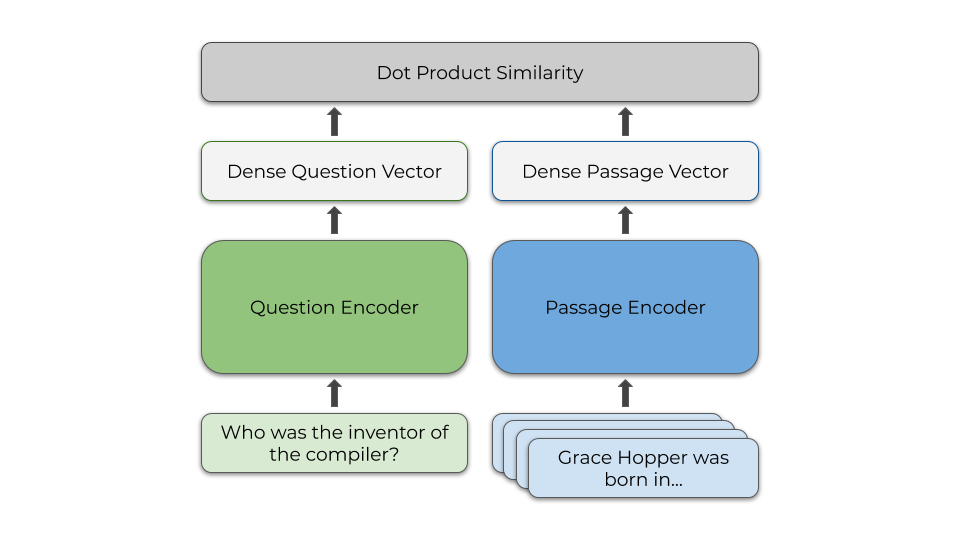


## Dataset and Search

We will use the same dataset as we used in the previous task, a [collection of financial questions and documents](https://huggingface.co/datasets/llmware/rag_instruct_test_dataset2_financial_0.1).  
We will first embed the and index the content, then create a class to retrieve queries based on the indexed content.  

In [3]:
# Load the corpus as a pandas dataset
financial_retrieval_corpus = pd.read_parquet("../../data/financial_retrieval_corpus.parquet")

# convert it into a HuggingFace dataset
financial_retrieval_ds = Dataset.from_pandas(financial_retrieval_corpus)

# Load an encoder (converting sentences into a vector, an embedding)
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", token=False)

# convert each sentence into an embedding:
financial_retrieval_ds = financial_retrieval_ds.map(
    lambda example: {"embeddings": embedder.encode(example["content"])}
)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

The semantic search process works as follows:

1. The search query is embedded using the same model that was used to embed the dataset.
2. The query embedding is compared against all document embeddings to find the top-k most similar items. As with TF-IDF search, cosine similarity is used to measure relevance.
3. The most relevant results are returned to the user.

The second step can take very long if the number of vectors is big. Therefore, we must index the vectors so we can quickly search for the best match.  
One such way of indexing is [**Hierarchical Navigable Small World (HNSW)**](https://aws.amazon.com/blogs/database/optimize-generative-ai-applications-with-pgvector-indexing-a-deep-dive-into-ivfflat-and-hnsw-techniques/). This technique automatically creates layers with a subset of these vectors, and enables reaching quickly to the nearest vector, based on some distance metric such as cosine-similarity.

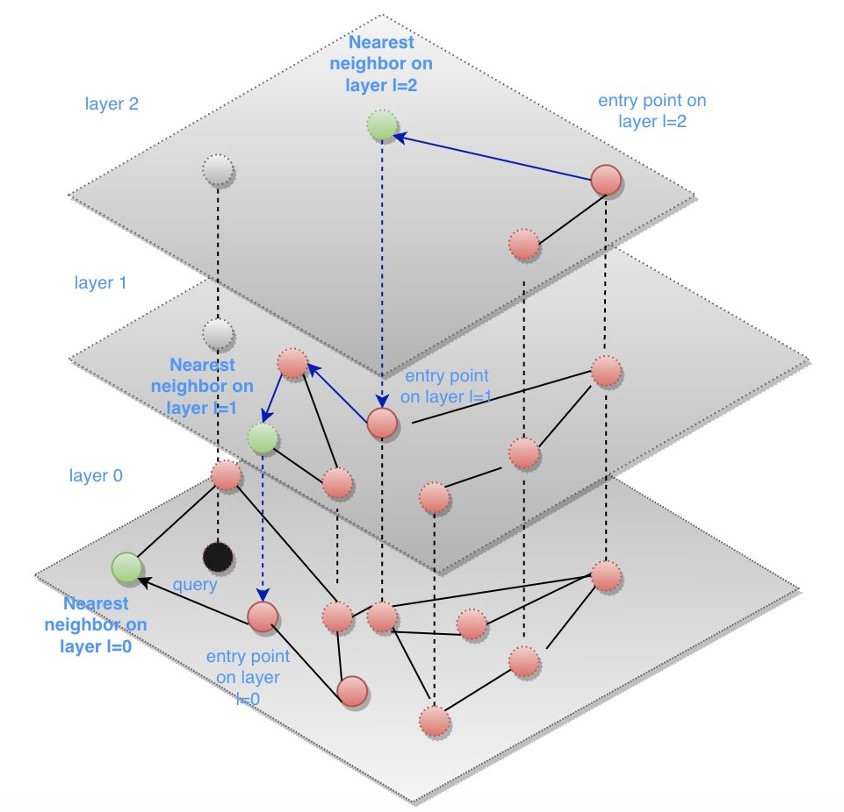

There are many of such vector-indexing solutions:
- [Milvus](https://milvus.io/)
- [FAISS](https://github.com/facebookresearch/faiss)
- [Qdrant](https://qdrant.tech/)
and others.

Today, even [MongoDB](https://www.mongodb.com/products/platform/atlas-vector-search) and [PostgreSQL](https://github.com/pgvector/pgvector) offfer vector indexing and similarity searches.

Let's build a retrieval model. This example is absed on [Huggingface's Search Index using FAISS Tutorial](https://huggingface.co/docs/datasets/en/faiss_es)

In [ ]:
class InformationRetrieval:
    """Handles the retreival of news articles from the corpus.

    Attributes:
        ds (Dataset): The news data corpus.
        embedding_model (SentenceTransformer): Embedding model for the text.
    """

    def __init__(self, ds: Dataset) -> None:
        """Initialize a new data retreiver over the corpus."""
        self.ds = ds
        self.embedding_model = SentenceTransformer(
            "sentence-transformers/all-MiniLM-L6-v2", token=False
        )

        # To quickly iterate over the vectors, we must index them.
        # We will use here FAISS index, as it is offered by default by Huggingface
        self.ds.add_faiss_index(column="embeddings")

    def search(self, query: str, top_k: int = 3) -> list[str]:
        """Search the corpus for the most similar articles.

        Args:
            query (str): Search query.
            top_k (int): Number of articles returned.

        Returns:
            list[str]: List of most similar articles.
        """
        query_embedding = self.embedding_model.encode(query)

        scores, retrieved_examples = self.ds.get_nearest_examples(
            "embeddings", query_embedding, k=top_k
        )
        return retrieved_examples["content"]

In [11]:
retriever = InformationRetrieval(financial_retrieval_ds)

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
retriever.search("What was the increase in revenue from the previous year?")

(array([1.0356785, 1.0459995, 1.0924293], dtype=float32),
 ['Outlook NVIDIA’s outlook for the third quarter of fiscal 2024 is as follows:Revenue is expected to be $16.00 billion, plus or minus 2%. GAAP and non-GAAP gross margins are expected to be 71.5% and 72.5%, respectively, plus or minus 50 basis points.  GAAP and non-GAAP operating expenses are expected to be approximately $2.95 billion and $2.00 billion, respectively.  GAAP and non-GAAP other income and expense are expected to be an income of approximately $100 million, excluding gains and losses from non-affiliated investments. GAAP and non-GAAP tax rates are expected to be 14.5%, plus or minus 1%, excluding any discrete items.Highlights NVIDIA achieved progress since its previous earnings announcement in these areas:  Data Center Second-quarter revenue was a record $10.32 billion, up 141% from the previous quarter and up 171% from a year ago. Announced that the NVIDIA® GH200 Grace™ Hopper™ Superchip for complex AI and HPC workl

If you experience problems indexing the dataset, use [this tutorial](https://huggingface.co/docs/datasets/en/faiss_es) to change the class above, and load the index using the method `.load_faiss_index()`.  
The index is stored here: `data/financial_retrieval_corpus_index.all-MiniLM-L6-v2.faiss`

## Task #1

Let's evaluate this retrieval.  
Run the retrieval over all the queries of `financial_retrieval_queries` dataset, and estimate how well does this retrieval works.

How does it compare to the TF-IDF and BM25 from the previous notebook?

In [14]:
### YOUR CODE HERE

## Task #2

Find a way to further improve this retrieval.

Here are some ideas for you to try:
- Using a different model? 
- Using different models for the query and the passage embeddings?
- Combining lexical (BM25) and semantic retrieval?

Evaluate by how much did you improve your model.

In [ ]:
### YOUR CODE HERE